# Lesson 10 - Sentiment Analysis

## Author: Emily McAfee

This assignment requires that you build a sentiment analysis classifier for a series of tweets.
The data consists of a file "twitter_data.csv". The file contains 16,000 tweets with their respective score. The attributes are the sentences, and the score is either 4 (for positive) or 0 (for negative).

Assignment Instructions
1. Complete all questions below.
2. Comment on the applicability of the model on future tweets.  

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import csv
import lda
import editdistance
import string
import re
import nltk
import numpy as np

# Specialty libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix
from collections import Counter
import argparse
import pprint
import gensim

nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/e.kubicek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/e.kubicek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read files
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/twitter_data.csv"
df = pd.read_csv(url, sep=",")
df.columns = ["sentiment_label","tweet_text"]
    
print(df.head())


   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


In [3]:
# Change sentiment from '0', '4' to '0', '1'
df1 = df.copy()
df1.sentiment_label = df1.sentiment_label.replace(4,1)

# Check data
print(df1.head())
print(df1['sentiment_label'].describe())
print(np.sum(df1['sentiment_label']))

   sentiment_label                                         tweet_text
0                1  @elephantbird Hey dear, Happy Friday to You  A...
1                1  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...
count    160000.000000
mean          0.500000
std           0.500002
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           1.000000
Name: sentiment_label, dtype: float64
80000


In [4]:
# Make list of tweets to use later
df_list = df1.values.tolist()

In [5]:
# Clean tweets then tokenize

# Create function to clean text data
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

step_list = ['remove_non_ascii', 'lowercase', 'remove_punctuation', 'remove_numbers',
            'strip_whitespace', 'remove_stopwords', 'stem_words']

# Check function
print(preprocess(df1.tweet_text[0], step_list))
print(df.tweet_text[0])

elephantbird hey dear happy friday already rice bowl lunch
@elephantbird Hey dear, Happy Friday to You  Already had your rice's bowl for lunch ?


In [6]:
# Apply function to tweet data (df1)
df1['clean_tweet'] = df1['tweet_text'].map(lambda s: preprocess(s, step_list))

In [7]:
# Check df
df1.head()

,sentiment_label,tweet_text,clean_tweet
0,1,"@elephantbird Hey dear, Happy Friday to You A...",elephantbird hey dear happy friday already ric...
1,1,Ughhh layin downnnn Waiting for zeina to co...,ughhh layin downnnn waiting zeina cook breakfast
2,0,"@greeniebach I reckon he'll play, even if he's...",greeniebach reckon hell play even he know noth...
3,0,@vaLewee I know! Saw it on the news!,valewee know saw news
4,0,very sad that http://www.fabchannel.com/ has c...,sad httpwwwfabchannelcom closed one web servic...


## Q1: Generate word cloud for positive sentiment.

In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#% matplotlib inline

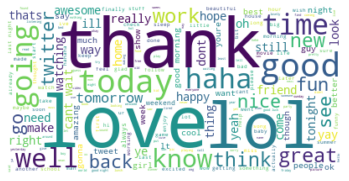

In [9]:
# Establish which columns will go in word cloud
positive = " ".join(review for review in df1.loc[df1.sentiment_label == 1,'clean_tweet'])

# What words do we not want to include
stopwords = set(STOPWORDS)

# Updated after first generation of word cloud
stopwords.update(["got", "im", "hey", "day", "one", 'amp'])

# Establish what we want generated in word cloud
wordcloud = WordCloud(stopwords = stopwords, background_color = "white").generate(positive)

# Plot it up
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Q2: Generate word cloud for negative sentiment.

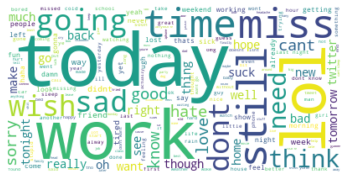

In [10]:
# Establish which columsn will go in word cloud
negative = " ".join(review for review in df1.loc[df1.sentiment_label == 0,'clean_tweet'])

# What words do we not want to include
stopwords = set(STOPWORDS)

# Updated after first generation of word cloud
stopwords.update(["one", "im", "hey", "day", "one", 'amp', 'ive', 'got'])

# Establish what we want generated in word cloud
wordcloud = WordCloud(stopwords = stopwords, background_color = "white").generate(negative)

# Plot it up
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [11]:
# Create a document storage matrix
clean_texts = df1['clean_tweet']
docs = {}
labels = []

for ix, row in enumerate(clean_texts):
    # Store the sentiment
    labels = df_list[ix][0]
    docs[ix] = row.split(' ')

# See sample/check
print(docs[np.random.choice(ix)])

['tgif', 'gumbo', 'red', 'right', 'interesting', 'tongue', 'collision', 'httptwitgoocomcnqr']


In [12]:
# Examine unique words
num_nonzero = 0
vocab = set()

# For each term in each tweet, add word to unique terms, add count to unique terms
for word_list in docs.values():
    unique_terms = set(word_list)
    vocab.update(unique_terms)
    num_nonzero += len(unique_terms)

doc_key_list = list(docs.keys())

# How many distinct words do we have
print(len(vocab))

144957


In [13]:
# Convert everything to a numpy array
doc_key_list = np.array(doc_key_list)
vocab = np.array(list(vocab))

# Keep track of vocab indices map to look up later
vocab_sorter = np.argsort(vocab)

# Look at vocab - sorted/unsorted
print(vocab[:5])
print(vocab[vocab_sorter[:5]])

['' 'shakehands' 'scalas' 'httpcrystaldermycom' 'ughthanks']
['' 'aa' 'aaa' 'aaaa' 'aaaaa']


In [14]:
# Intialize sparse matrix for tweets
num_docs = len(doc_key_list)
vocab_size = len(vocab)

# Create COO matrix (all nonzero, row index, column index)
data = np.empty(num_nonzero, dtype = np.intc)
rows = np.empty(num_nonzero, dtype = np.intc)
cols = np.empty(num_nonzero, dtype = np.intc)

In [15]:
ix = 0
# Iterate through all documents with terms
print('Almost there...')

for doc_key, terms in docs.items():
    
    # Insert data into indices
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter = vocab_sorter)]
    
    # Count unique terms (of docs) and get voca indices
    uniq_indices, counts = np.unique(term_indices, return_counts = True)
    # # of unique terms
    n_vals = len(uniq_indices)
    # Add count to index
    ix_end = ix + n_vals
    
    # Save counts (term frequencies)
    data[ix:ix_end] = counts
    # Save column index
    cols[ix:ix_end] = uniq_indices
    # Document index for the document name
    doc_ix = np.where(doc_key_list == doc_key)
    # Save value as repeated
    rows[ix:ix_end] = np.repeat(doc_ix, n_vals)
    
    # Continue with next document - will continue to add future data on the end
    ix = ix_end

print('See? All done!')

Almost there...
See? All done!


In [16]:
# Check sorted vocabulary again - first 5
vocab[vocab_sorter[:5]]

array(['', 'aa', 'aaa', 'aaaa', 'aaaaa'], dtype='<U109')

In [17]:
# Creat sparse matrix for tweet data
doc_term_mat = coo_matrix((data, (rows, cols)), shape = (num_docs, vocab_size), dtype = np.intc)

In [18]:
# Trim the doc-term matrix
word_counts = doc_term_mat.sum(axis = 0)
print(word_counts)

[[40  1  1 ...  1  1  1]]


In [19]:
# Look at words above a particular cut off point
cutoff = 15
word_count_list = word_counts.tolist()[0]

# Find which column indices are above cutoff point
col_cutoff_ix = [ix for ix, count in enumerate(word_count_list) if count > cutoff]

# of words w/counts above 15
len(col_cutoff_ix)

5741

In [20]:
# Clean up the vocabulary (trim)
vocab_trimmed = np.array([vocab[x] for x in col_cutoff_ix])

# Sort vocab again
vocab_sorter_trimmed = np.argsort(vocab_trimmed)

# Before trimming shape
print(doc_term_mat.shape)

# trim doc-term matrix
doc_term_mat_trimmed = doc_term_mat.tocsc()[:,col_cutoff_ix]

# After trimming shape
doc_term_mat_trimmed.shape

(160000, 144957)


(160000, 5741)

In [21]:
# Look at sorted data
vocab_trimmed[vocab_sorter_trimmed[0:10]]

array(['', 'aa', 'aaa', 'aaaah', 'aaah', 'aah', 'aaron', 'ab',
       'abandoned', 'abby'], dtype='<U37')

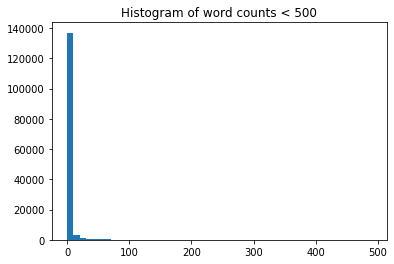

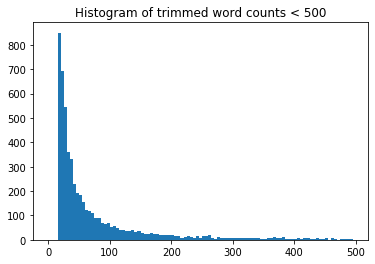

In [22]:
# Plot frequency of data
# Count of words for each appearance
hist_breaks = np.arange(0, 500, 10)
plt.hist(word_count_list, bins = hist_breaks)
plt.title('Histogram of word counts < 500')
plt.show()

# Too many words appear few times. Check out trimmed.
trimmed_word_counts = doc_term_mat_trimmed.sum(axis=0)
trimmed_word_list = trimmed_word_counts.tolist()[0]
hist_breaks = np.arange(0, 500, 5)
plt.hist(trimmed_word_list, bins = hist_breaks)
plt.title('Histogram of trimmed word counts < 500')
plt.show()

In [23]:
# Declare the TFIDF vectorizer
vectorizer = TfidfVectorizer(sublinear_tf = True, max_df = 0.5, max_features = 5741, stop_words = 'english')

# Fit vectorizer over the dataset
clean_text = df1['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

In [24]:
# Examine the Compressed Sparse Row Format (CSR) for scikit-learn
tf_idf_tweets

<160000x5741 sparse matrix of type '<class 'numpy.float64'>'
	with 839748 stored elements in Compressed Sparse Row format>

## Q3: Split data into 70% for training and 30% for testing.

In [25]:
# Classification + sentiment analysis (train on 112,000 tweets, test on 48,000 tweets)
# Make 48,000 random row indices
print('Splitting data into train-test...')

# Import sklearn package for train-test
from sklearn.model_selection import train_test_split

# Establish target
y_targets = np.array([y[0] for y in df_list])

# Establish tweets as features
x_train, x_test, y_train, y_test = train_test_split(tf_idf_tweets,
                                                   y_targets,
                                                   test_size = 48000,
                                                   random_state = 42)
print('Done!')

Splitting data into train-test...
Done!


## Q4: Build a classifier that classifies the sentiment of a sentence.

In [26]:
# Train a logistic classifier on the tweet data
print('Initializing a standard Logistic Model training (nice).')

# Import sklearn package
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train,y_train)
print('Done!')

Initializing a standard Logistic Model training (nice).


/Users/e.kubicek/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Done!


In [27]:
# Check model object
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Q5: What is the accuracy of your model when applied to testing data?

In [28]:
# Evaluate the logistic regression model
# Compute results on train/test set (probabilities)
train_proba = lr.predict_proba(x_train)
train_results = np.argmax(train_proba, axis = 1)

test_proba = lr.predict_proba(x_test)
test_results = np.argmax(test_proba, axis = 1)

# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

# Train accuracy
print('Train accuracy =', train_acc)

#Test accuracy
print('Test accuraccy =', test_acc)

Train accuracy = 0.7789196428571429
Test accuraccy = 0.7538958333333333


In [29]:
# Our train accuracy is better then our test accuracy - 
# this suggests that our model is overfi to the training data - 
# let's try to improve that with some regularization
print('Currently training the regularized logistic regression...')

# Import sklearn package
from sklearn.linear_model import SGDClassifier

# Apply regularizaiton to the logistic regression
lr_reg = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15)
lr_reg.fit(x_train, y_train)

print('Done!')

Currently training the regularized logistic regression...
Done!


In [30]:
# Evaluate how the elasticnet regularization did
train_probs = lr_reg.predict_proba(x_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr_reg.predict_proba(x_test)
test_results = np.argmax(test_probs, axis=1)

In [31]:
# Compute (new) accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy NOW =', train_acc)
print('Test accuracy NOW =', test_acc)

Train accuracy NOW = 0.7533303571428571
Test accuracy NOW = 0.7447916666666666


## Q6: What conclusions can you draw from the model?

The first model we built to predict sentiment of our tweet data had an accuracy of about 77% on our training data and about 75% on our test data. While these numbers are high and that may seem good, we have to examine the differences in accuracies between the two. Because the accuracy on the train data is a few percentages higher than that of the test data, this suggests that the model is overfit to the training data. to imporvie upon this, we apply regularization to the logistic regression model. After regularization, the accuracy on our test data remains relatively high (74%), and becomes closer to our test data accuracy (75%). This means our model is likley more generalizable to incoming similar data.

## Q7: Is it better to have a model per source?

I would say that it is better to have a model per source, as each model is trained on the data it is given. As stated previously in the lesson, models of this type are often used to identify similarities across texts, if it is written but the same author, etc. If the model were to be the same across all sources for every document, the training would not be reliable enough to apply to new and/or unrelated sources. However, if the tweet coming in is from a similar source as the previous tweets have (i.e. geographical region, containing certain topics), I think the model would be improve by the additional data points.